# Housing Prices Model for Ames, Iowa
For my first machine learning project I'll use the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) data set from Kaggle. The goal will be to create a regression model to predict the sale price of houses in Ames, Iowa.

### Load the Data
I'll pull the data from the Thinkful PostgreSql database using my credentials.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import seaborn as sns

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [2]:
## thinkful credentials
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
#pull the data
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

### Data Cleaning

In [4]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

#### Missing Data

In [6]:
## print columns with missing values and the percentage missing
total_missing = housing_df.isnull().sum().sort_values(ascending=False)
percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995
miscfeature,1406,0.963
alley,1369,0.938
fence,1179,0.808
fireplacequ,690,0.473
lotfrontage,259,0.177
garagecond,81,0.055
garagetype,81,0.055
garageyrblt,81,0.055
garagefinish,81,0.055


Let's go through the list of columns with missing values. If they are important enough to keep then we can clean them. If they have a related column or they aren't relevant to our model, we can discard them:

1. Pool quality can be dicarded, since we have pool sq ft.
2. Miscfeature is too ambiguous to use.
3. Alley is missing 93% of it's data, discarded.
4. Fence quality with 80% missing doesn't seem to be a relevant feature.
5. Fireplace quality can be replaced by # of fireplaces column if we need it.
6. Lot frontage isn't as important as lot area, discarded.
7. Size of garage can be used instead of any other garage column.
8. Basement area will be used in place of other basement features.
9. Perhaps we can use masonry columns if we need to, but it doesn't seem important.

It looks like we can drop all of these columns and not sacrifice much at all. 

In [7]:
##drop all columns that contain a null value
trim_housing1 = housing_df.dropna(axis='columns')

### Exploration
Let's start to explore by understanding our target variable: **saleprice.**

Text(0, 0.5, 'Density')

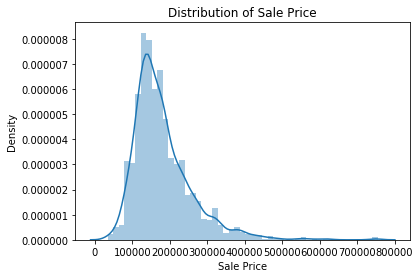

In [8]:
sns.distplot(trim_housing1.saleprice)
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price")
plt.ylabel("Density")

Our target variable is non-normally distributed and skewed to the right.

In [9]:
##print categorical columns
categorical_columns = trim_housing1.select_dtypes(['object']).columns
print(categorical_columns)
print("The number of non-numerical columns is {}".format(len(categorical_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating',
       'heatingqc', 'centralair', 'kitchenqual', 'functional', 'paveddrive',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 27


In [10]:
## print numeric columns
numeric_columns = trim_housing1.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars',
       'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch',
       'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold',
       'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 35


We are about evenly split between categorical and continuous variables. We'll need to convert categorical ones to numeric, as well as deal with intercorrelated variables by either combining them or discarding some. Let's explore the numeric categories correlations' to the target first.

In [11]:
## print the absolute value of correlations to saleprice
np.abs(trim_housing1[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice       1.000
overallqual     0.791
grlivarea       0.709
garagecars      0.640
garagearea      0.623
totalbsmtsf     0.614
firstflrsf      0.606
fullbath        0.561
totrmsabvgrd    0.534
yearbuilt       0.523
yearremodadd    0.507
fireplaces      0.467
bsmtfinsf1      0.386
wooddecksf      0.324
secondflrsf     0.319
openporchsf     0.316
halfbath        0.284
lotarea         0.264
bsmtfullbath    0.227
bsmtunfsf       0.214
bedroomabvgr    0.168
kitchenabvgr    0.136
enclosedporch   0.129
screenporch     0.111
poolarea        0.092
mssubclass      0.084
overallcond     0.078
mosold          0.046
threessnporch   0.045
yrsold          0.029
lowqualfinsf    0.026
miscval         0.021
bsmthalfbath    0.017
bsmtfinsf2      0.011
Name: saleprice, dtype: float64

Many of the columns seem to split up a more obvious category, such as total square footage or total number of bathrooms. Let's create those features, then discard the ones they replaced.

In [12]:
##create total sq ft feature
trim_housing1['totalsf'] = trim_housing1['totalbsmtsf'] + trim_housing1['firstflrsf'] + trim_housing1['secondflrsf']
##create total bathrooms feature
trim_housing1['totalbathrooms'] = (trim_housing1['fullbath'] + (0.5 * trim_housing1['halfbath']) +
trim_housing1['bsmtfullbath'] + (0.5 * trim_housing1['bsmthalfbath']))
##create total porch sq ft feature
trim_housing1['totalporchsf'] = (trim_housing1['openporchsf'] + trim_housing1['threessnporch'] +
trim_housing1['enclosedporch'] + trim_housing1['screenporch'] +
trim_housing1['wooddecksf'])
##drop columns that have been combined into another feature
trim_housing2 = trim_housing1.drop(columns=['totalbsmtsf', 'firstflrsf', 'secondflrsf','fullbath','halfbath',
                                            'bsmtfullbath','bsmthalfbath','openporchsf','threessnporch','enclosedporch',
                                           'screenporch','wooddecksf'])

In [13]:
## reset numeric columns variable
numeric_columns = trim_housing2.select_dtypes(['int64', 'float64']).columns
## reprint correlations
np.abs(trim_housing2[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000
overallqual      0.791
totalsf          0.782
grlivarea        0.709
garagecars       0.640
totalbathrooms   0.632
garagearea       0.623
totrmsabvgrd     0.534
yearbuilt        0.523
yearremodadd     0.507
fireplaces       0.467
totalporchsf     0.391
bsmtfinsf1       0.386
lotarea          0.264
bsmtunfsf        0.214
bedroomabvgr     0.168
kitchenabvgr     0.136
poolarea         0.092
mssubclass       0.084
overallcond      0.078
mosold           0.046
yrsold           0.029
lowqualfinsf     0.026
miscval          0.021
bsmtfinsf2       0.011
Name: saleprice, dtype: float64

It's time to select which numeric features to use for our model. We'll do our best to avoid obvious multicolinearity now, such as using total sq ft but not living room sq ft, and test for it later when we've trimmed down our features.

In [14]:
##create new df with selected features
model_features = trim_housing2[['saleprice','overallqual','totalsf','garagecars','totalbathrooms']].copy()

In [15]:
##print correlations
model_features.corr()

,saleprice,overallqual,totalsf,garagecars,totalbathrooms
saleprice,1.000,0.791,0.782,0.640,0.632
overallqual,0.791,1.000,0.668,0.601,0.541
totalsf,0.782,0.668,1.000,0.536,0.604
garagecars,0.640,0.601,0.536,1.000,0.484
totalbathrooms,0.632,0.541,0.604,0.484,1.000


In [16]:
## drop garage cars and total bathrooms
model_features = trim_housing2[['saleprice','overallqual','totalsf']].copy()

It looks like garage cars and total bathrooms is correlated to total sq ft, which makes sense. Let's drop down to only overall quality and sq ft, and add a couple of categorical columns. Let's explore those to select some as features.

In [17]:
##print categorical columns
categorical_columns

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating',
       'heatingqc', 'centralair', 'kitchenqual', 'functional', 'paveddrive',
       'saletype', 'salecondition'],
      dtype='object')

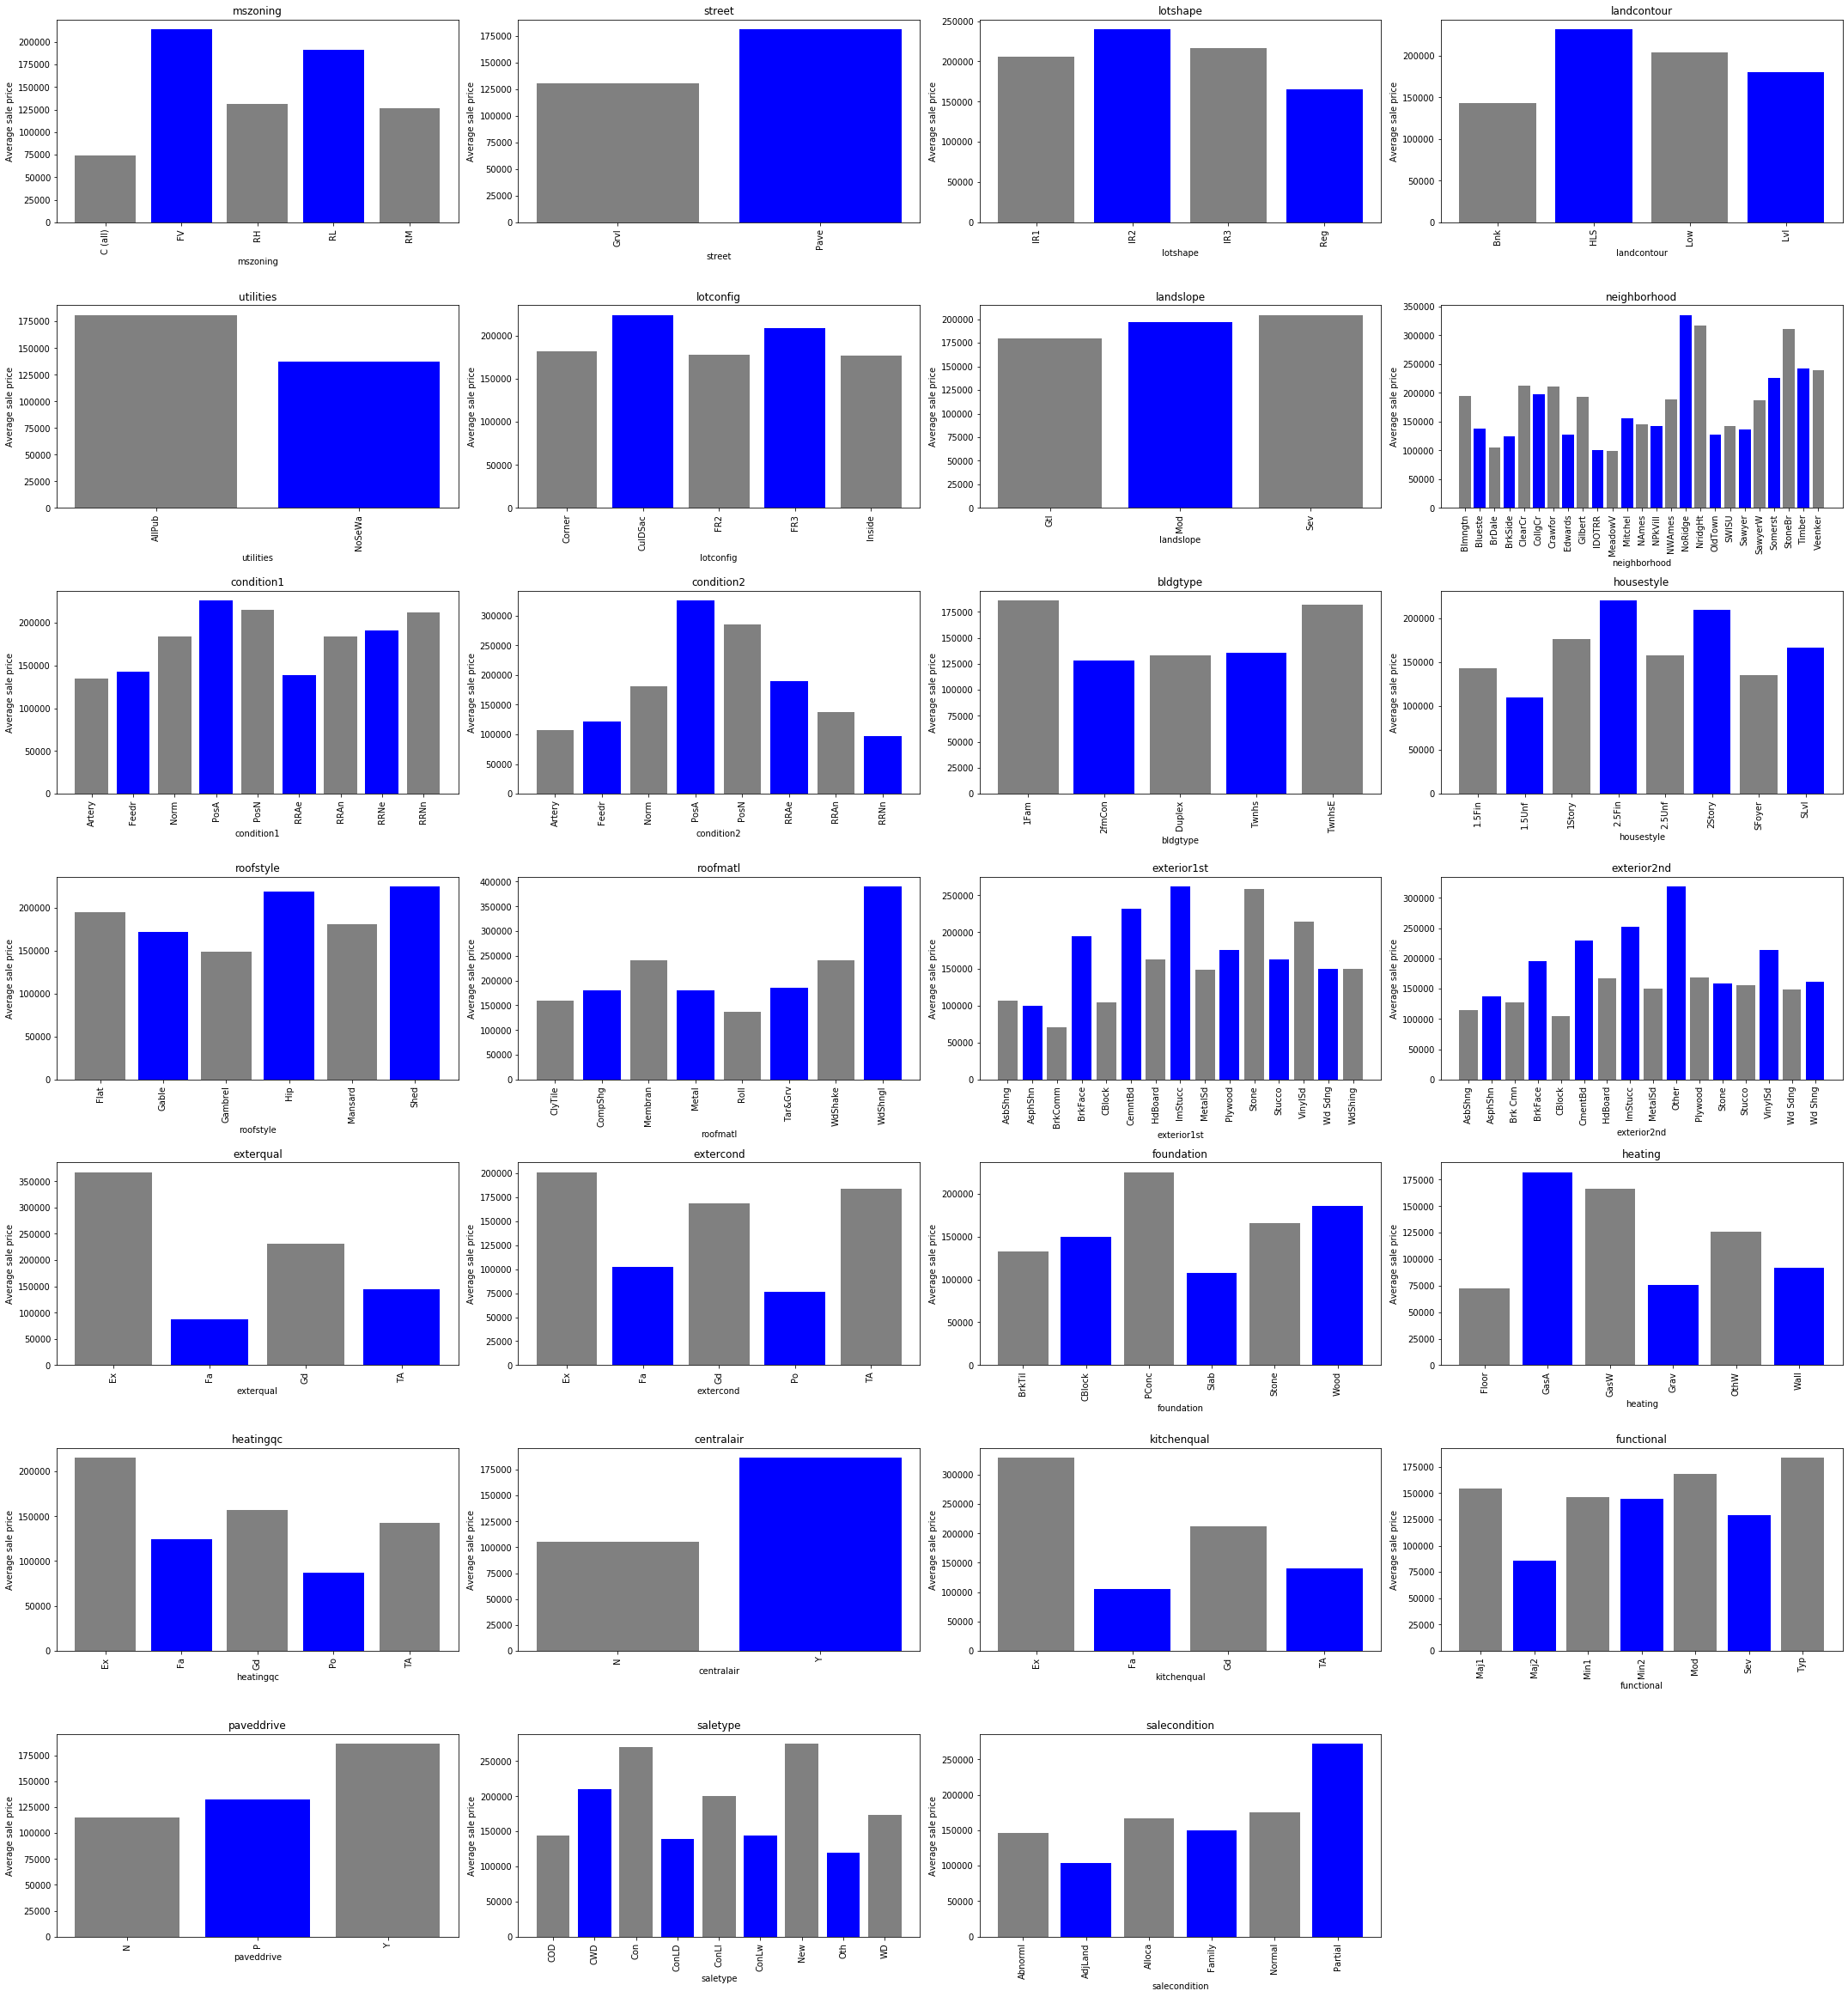

In [18]:
## display saleprice grouped by categorical variables
plt.figure(figsize=(30,50))

for index, column in enumerate(categorical_columns):
    plt.subplot(11,4,index+1)
    plt.bar(trim_housing2.groupby(column)["saleprice"].mean().index, trim_housing2.groupby(column)["saleprice"].mean(),
           color=("grey","blue"))
    plt.title(column)
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

There's several that could be used. Let's start by looking closer at neighborhood and housestyle, since they seem intuitively important, and their graphs show some variance with respect to saleprice.

In [19]:
##create grouped neighborhood variable and sort it
neighborhood_grouped = trim_housing2.groupby("neighborhood")["saleprice"].mean().reset_index()
neighborhood_grouped = neighborhood_grouped.sort_values(by=['saleprice'], ascending=False).reset_index()

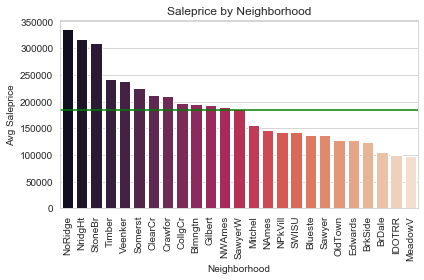

In [20]:
##plot neighborhood
sns.set_style("whitegrid")
sns.barplot(x='neighborhood', y='saleprice', data=neighborhood_grouped,palette="rocket")
plt.title("Saleprice by Neighborhood")
plt.ylabel("Avg Saleprice")
plt.xlabel("Neighborhood")
plt.xticks(rotation=90)
plt.axhline(neighborhood_grouped['saleprice'].mean(), color='g')

plt.tight_layout()
plt.show()

Here's a closer look at the avg saleprice per neighborhood. The green line is the average saleprice for all neighborhoods. The mean looks like a perfect cutoff point to sort these neighborhoods into two categories so we can implement neighborhood into the model as a dummy feature.

In [21]:
rich_neighborhood = ['NoRidge','NridgHt','StoneBr','Timber','Veenker','Somerst','ClearCr','Crawfor',
                     'CollgCr','Blmngtn','Gilbert','NWAmes','SawyerW']
poor_neighborhood = ['Mitchel', 'NAmes', 'NPkVill', 'SWISU', 'Blueste',
       'Sawyer', 'OldTown', 'Edwards', 'BrkSide', 'BrDale', 'IDOTRR',
       'MeadowV']

In [22]:
#change neighborhood to 1 for rich and 0 for poor
trim_housing2.loc[trim_housing2['neighborhood'].isin(rich_neighborhood)==True, 'neighborhood'] = 1

In [23]:
trim_housing2.loc[trim_housing2['neighborhood'].isin(poor_neighborhood)==True, 'neighborhood'] = 0

In [24]:
##check to see it worked
trim_housing2['neighborhood'].unique()

array([1, 0], dtype=int64)

In [25]:
##turn into dummy
model_features['location'] = pd.get_dummies(trim_housing2['neighborhood'], drop_first=True)

In [26]:
model_features.corr()

,saleprice,overallqual,totalsf,location
saleprice,1.000,0.791,0.782,0.584
overallqual,0.791,1.000,0.668,0.609
totalsf,0.782,0.668,1.000,0.418
location,0.584,0.609,0.418,1.000


### Regression Model
Let's start with these intuitively important features, and modify our model down the road if we need to.

In [27]:
Y = model_features['saleprice']
X = model_features[['overallqual','totalsf','location']]
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1511.
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:10:45   Log-Likelihood:                -17512.
No. Observations:                1460   AIC:                         3.503e+04
Df Residuals:                    1456   BIC:                         3.505e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.205e+04   5134.936    -15.980      0.000   -9.21e+04    -7.2e+04
overallqual  2.257e+04   1143.199     19.741      0.000    2.03e+04    2.48e+04
totalsf        44.0246      1.679     26.215      0.000      40.730      47.319
location     2.446e+04   2589.056      9.448      0.000    1.94e+04    2.95e+04
==============================================================================
Omnibus:                      441.510   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46591.709
Skew:                          -0.289   Prob(JB):                         0.00
Kurtosis:                      30.669   Cond. No.                     1.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared is 0.757, so we have room for improvement. Since the saleprice variable was not normally distributed, let's apply a log transform to improve our goodness of fit.

In [28]:
Y = np.log1p(model_features['saleprice'])
X = model_features[['overallqual','totalsf','location']]
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1890.
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:10:45   Log-Likelihood:                 427.95
No. Observations:                1460   AIC:                            -847.9
Df Residuals:                    1456   BIC:                            -826.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.7049      0.024    452.269      0.000      10.658      10.751
overallqual     0.1170      0.005     22.201      0.000       0.107       0.127
totalsf         0.0002   7.74e-06     25.961      0.000       0.000       0.000
location        0.1781      0.012     14.925      0.000       0.155       0.202
==============================================================================
Omnibus:                      889.936   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26790.817
Skew:                          -2.314   Prob(JB):                         0.00
Kurtosis:                      23.469   Cond. No.                     1.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Log transforming the target variable improved our R-squared to 0.796. Let's start testing our model!

### Training and Testing
We are going to test Lasso, Ridge and ElasticNet regression models to see which one works best.

In [29]:
#reset the variables
Y = np.log1p(model_features['saleprice'])
X = model_features[['overallqual','totalsf','location']]
X = sm.add_constant(X)
#seperate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


#### OLS

In [30]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.7889765049194554
-----Test set statistics-----
R-squared of the model in test set is: 0.8190941309776474
Mean absolute error of the prediction is: 0.13006216712316743
Mean squared error of the prediction is: 0.030165266504916875
Root mean squared error of the prediction is: 0.17368150881690564
Mean absolute percentage error of the prediction is: 1.091292985999584


#### Ridge

In [31]:
ridgeregr = RidgeCV() 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7889764975862386
-----Test set statistics-----
R-squared of the model on the test set is: 0.81909323881179
Mean absolute error of the prediction is: 0.13005962883330463
Mean squared error of the prediction is: 0.030165415269691596
Root mean squared error of the prediction is: 0.17368193708526974
Mean absolute percentage error of the prediction is: 1.0912723582366983


#### Lasso

In [32]:
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 6.706638977452912
R-squared of the model in training set is: 0.5851737449964585
-----Test set statistics-----
R-squared of the model in test set is: 0.6651209771227502
Mean absolute error of the prediction is: 0.17994402292315623
Mean squared error of the prediction is: 0.055839619944835675
Root mean squared error of the prediction is: 0.236304083639779
Mean absolute percentage error of the prediction is: 1.5022308071287183


#### ElasticNet

In [33]:
elasticregr = ElasticNetCV(l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.5852272981198998
-----Test set statistics-----
R-squared of the model on the test set is: 0.6654914787419131
Mean absolute error of the prediction is: 0.17985815216765355
Mean squared error of the prediction is: 0.055777840411960655
Root mean squared error of the prediction is: 0.23617332705443403
Mean absolute percentage error of the prediction is: 1.5015109677505751


The Lasso and ElasticNet regressions make our model much worse. There is almost zero difference between the Ridge and OLS regressions, so we'll keep our OLS model.

### Prediction

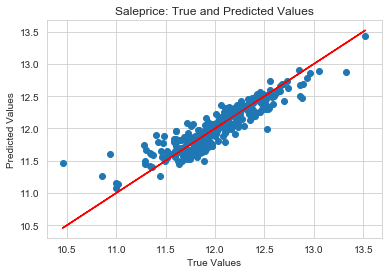

Mean absolute error of the prediction is: 0.12902310516149892
Mean squared error of the prediction is: 0.02963813000257667
Root mean squared error of the prediction is: 0.1721572827462628
Mean absolute percentage error of the prediction is: 1.0827570825186676


In [34]:
# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Saleprice: True and Predicted Values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Our model looks good! All of our metrics are close to zero.

### External Factors
The most obvious external factor dealing with housing prices is the Great Recession in 2009 due to the collapse of the housing market. Let's see if the data reflects it.

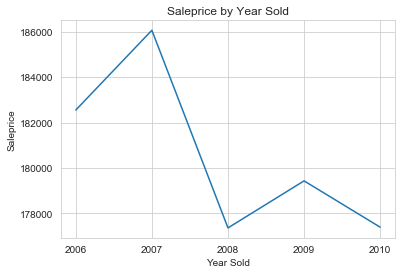

In [35]:
##group the data by year sold
yrsold_grouped = trim_housing2.groupby('yrsold')['saleprice'].mean().reset_index()
yrsold_grouped['yrsold'] = yrsold_grouped['yrsold'].apply(str)
recession = sns.lineplot(x='yrsold', y='saleprice',data=yrsold_grouped)
plt.xlabel("Year Sold")
plt.ylabel("Saleprice")
plt.title("Saleprice by Year Sold")
plt.show()

There it is. In order to incorporate it into the model we can have a pre- and post-recession feature.

In [36]:
## turn into dummies for pre and post recession
trim_housing2.loc[trim_housing2['yrsold'] < 2008] = 1

In [37]:
trim_housing2.loc[trim_housing2['yrsold'] >= 2008] = 0

In [38]:
model_features['recession'] = pd.get_dummies(trim_housing2['yrsold'], drop_first=True)

Now we'll add the recession feature to the model and implement it again.

In [41]:
#reset the variables
Y = np.log1p(model_features['saleprice'])
X = model_features[['overallqual','totalsf','location','recession']]
X = sm.add_constant(X)
##fit the model
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1417.
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:15:01   Log-Likelihood:                 428.11
No. Observations:                1460   AIC:                            -846.2
Df Residuals:                    1455   BIC:                            -819.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.7027      0.024    445.600      0.000      10.656      10.750
overallqual     0.1171      0.005     22.203      0.000       0.107       0.127
totalsf         0.0002   7.75e-06     25.913      0.000       0.000       0.000
location        0.1779      0.012     14.895      0.000       0.154       0.201
recession       0.0053      0.010      0.556      0.578      -0.013       0.024
==============================================================================
Omnibus:                      887.236   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26533.667
Skew:                          -2.306   Prob(JB):                         0.00
Kurtosis:                      23.369   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

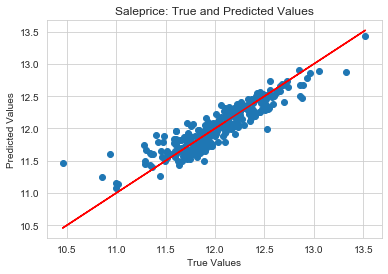

Mean absolute error of the prediction is: 0.128908230097969
Mean squared error of the prediction is: 0.029595942596886835
Root mean squared error of the prediction is: 0.1720347133484601
Mean absolute percentage error of the prediction is: 1.0817869973639693


In [42]:
# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Saleprice: True and Predicted Values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Conclusion
The R-squared values of the initial model and the latter model are identical at .796. The reason our recession attribute doesn't contribute very much to our model is that the sample size of year sold is only 5 years long. It would be much more beneficial to have many more decades to include.